# Combat Elite Analysis Task

## Background

- Combat Elite is a game in which players play in a 4-player team made up of mixtures of real players and/or bots.
- There are 3 match types that are available in turns in a cycle to the player.
- Combat Elite has products which can be bought with real money, known as in-app purchases (IAPs), as well as products that can be bought with the in-game virtual currency, Gold.

## Objectives

There is an upcoming update for Combat Elite, this notebook will analyse key metric areas for the game and look to provide insights as to what changes could be made to improve the game.

## Data Sources

There are four data sources provided for this analysis:

1. `data_daily_activity.csv` 
   - Contains the daily activity of the users. 
   - Each row represents a user who opened the game on that specific day. 

2. `data_matches.csv`
   - Contains all matches played during the analysis period per user. 
   - Each row represents a day of matches.

3. `data_in_app_purchases.csv`
   - Contains all the in-app purchases made during the analysis period per user.
   - Each row represents a transaction. 

4. `data_virtual_purchases.csv`
   - Contains all the purchases made using gold during the analysis period per user. 
   - Each row represents a day of transactions. 


## Setup and Cleaning

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
activity = pd.read_csv("data_daily_activity.csv")
matches = pd.read_csv("data_matches.csv")
iap = pd.read_csv("data_in_app_purchases.csv")
vp = pd.read_csv("data_virtual_purchases.csv")

# Remove the incrementing ID given to records
matches = matches.drop(columns=['Unnamed: 0'])
activity = activity.drop(columns=['Unnamed: 0'])
iap = iap.drop(columns=['Unnamed: 0'])
vp = vp.drop(columns=['Unnamed: 0'])

# Ensure all platform names are standardised
activity['platform'] = activity['platform'].str.lower()

# Standardise column types
matches['user_id'] = matches['user_id'].astype(int)
matches["finish_position"] = pd.to_numeric(matches["finish_position"], errors='coerce')
matches["finish_position"] = matches["finish_position"].astype('Int64')

# Convert 'activity_date' to datetime
iap['activity_date'] = pd.to_datetime(iap['activity_date'])
matches['activity_date'] = pd.to_datetime(matches['activity_date'])
vp['activity_date'] = pd.to_datetime(vp['activity_date'])
activity['activity_date'] = pd.to_datetime(activity['activity_date'])

# Once sanitised, remove duplicates
matches = matches.drop_duplicates()
activity = activity.drop_duplicates()
iap = iap.drop_duplicates()
vp = vp.drop_duplicates()


# General Functions
def format_label(label, pct, raw):
    """Formats a label to contain a string, the percentage and a raw value."""
    absolute = int(round(pct/100.*sum(raw)))
    return f"{label}\n{pct:.1f}%\n({absolute:d})"

## Understanding the Player Base

It is important to understand the player base which makes up Combat Elite's users as this can inform how the game is being played.

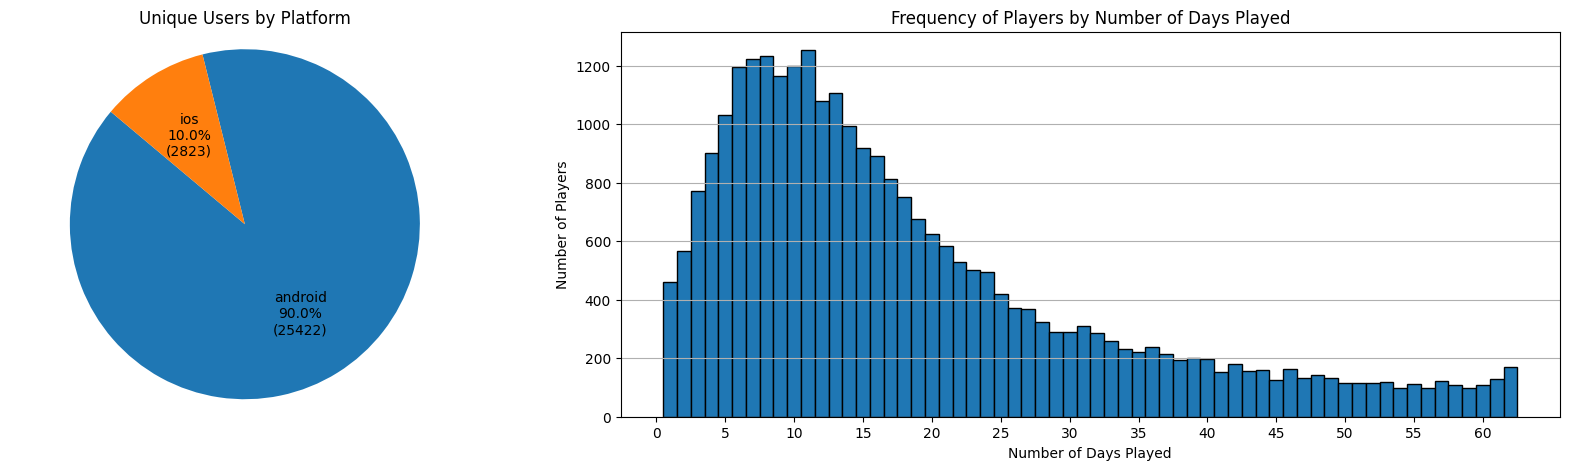

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 2]})

users_by_platform = activity.groupby('platform')['user_id'].nunique()
labels = users_by_platform.index.tolist()


ax1.pie(users_by_platform, autopct=lambda pct: format_label(labels.pop(0), pct, users_by_platform), startangle=140)
ax1.set_title('Unique Users by Platform')
ax1.axis('equal')

plays_by_day = activity.drop_duplicates(subset=['user_id', 'activity_date'])
unique_plays_by_day = plays_by_day.groupby('user_id').size()

ax2.hist(unique_plays_by_day, bins=range(1, unique_plays_by_day.max() + 2), align='left', edgecolor='black')
ax2.set_xlabel('Number of Days Played')
ax2.set_ylabel('Number of Players')
ax2.set_title('Frequency of Players by Number of Days Played')
ax2.set_xticks(range(0, unique_plays_by_day.max() + 1, 5))
ax2.grid(axis='y')

plt.show()

Looking at the users by platform:

- Android dominates the market share for Combat Strike with 90% of the player base.
- 15 users (0.053%) accessed the game on both iOS and Android
  - The low rate of cross-platform play is not a surprising statistic as most users will not own more than one mobile device.

The dataset covers a period of 62 days, within this it can be seen that:

- The majority of users opened the app between 4-17 days
- 171 Users (0.6%) played every day across the 62-day period


## Matches Analysis

### Platforms

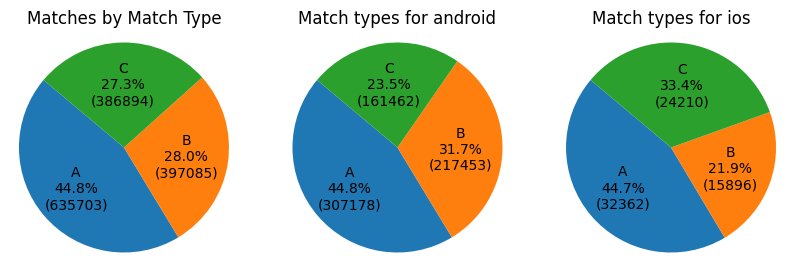

In [6]:
matches_by_type = matches.groupby('match_type').agg({'n_matches': 'sum'}).reset_index()
matches_by_type.columns = ['match_type', 'total_matches']
labels = matches_by_type['match_type'].tolist()


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 3))

ax1.set_title('Matches by Match Type')
ax1.pie(matches_by_type['total_matches'], autopct=lambda pct: format_label(labels.pop(0), pct, matches_by_type['total_matches']), startangle=140)
ax1.axis('equal')


# Group by platform and match_type, and sum the number of matches
matches_by_platform_type = pd.merge(activity, matches, on=['user_id', 'activity_date'], how='inner')
matches_by_platform_type = matches_by_platform_type.groupby(['platform', 'match_type']).agg({'n_matches': 'sum'}).reset_index()

for platform, plot in zip(matches_by_platform_type['platform'].unique(), [ax2, ax3]):
    subset = matches_by_platform_type[matches_by_platform_type['platform'] == platform]
    labels = matches_by_platform_type['match_type'].tolist()
    plot.pie(subset['n_matches'], autopct=lambda pct: format_label(labels.pop(0), pct, subset['n_matches']), startangle=140)
    plot.axis('equal')
    plot.set_title(f"Match types for {platform}")

plt.show()

- Match type distribution remains fairly consistent across the different platforms
- Match Type A makes up nearly half of all matches played in Combat Elite

### Performance


An increasing number of Bots are shown to have a near negligible impact on performance. It only matters that there is at least one other human as this does show a notable improvement in performance.

| # of Bots | Final Position |
| ------------------ | -------------- |
| 0                  | 2.581627       |
| 1                  | 2.580243       |
| 2                  | 2.544385       |
| 3                  | 2.099232       |

### Retention

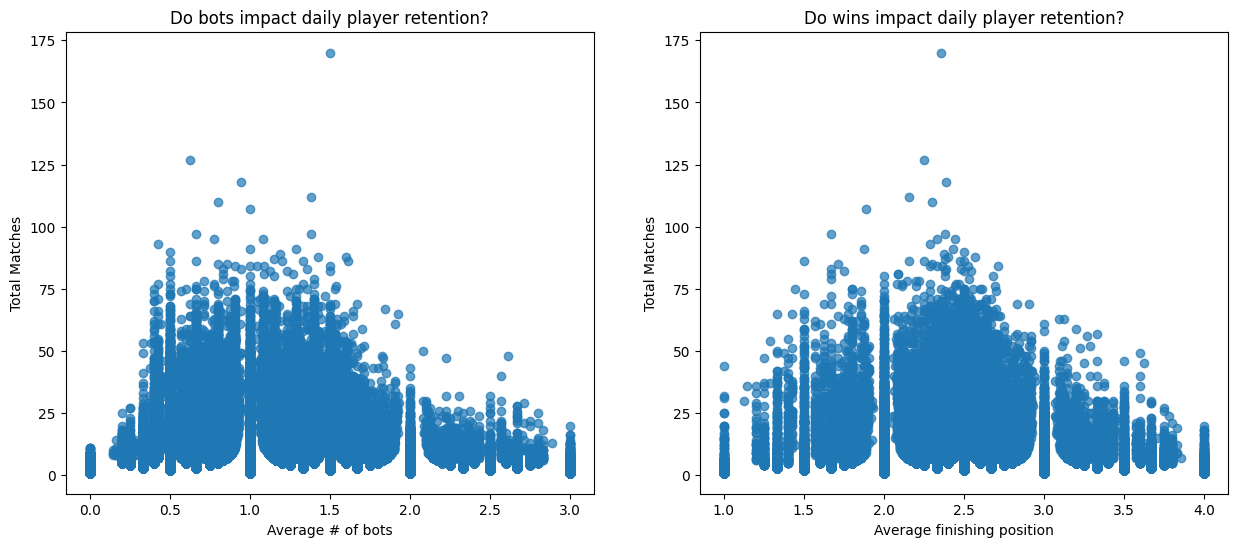

In [7]:
# Matches grouped by each players activity for a single day.
matches_agg = matches.groupby(['user_id', 'activity_date']).agg({
    'finish_position': ['mean', 'min', 'max'],
    'bots': 'mean',
    'n_matches': 'sum',
}).reset_index()
matches_agg.columns = ['user_id', 'activity_date', 'avg_finish_position', 'min_finish_position', 'max_finish_position', 'avg_bots', 'total_matches']
matches_agg = matches_agg.dropna(subset=['total_matches', 'avg_finish_position'])


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))

ax1.set_title('Do bots impact daily player retention?')
ax1.scatter(matches_agg['avg_bots'], matches_agg['total_matches'], alpha=0.7)
ax1.set_xlabel('Average # of bots')
ax1.set_ylabel('Total Matches')

ax2.set_title('Do wins impact daily player retention?')
ax2.scatter(matches_agg['avg_finish_position'], matches_agg['total_matches'], alpha=0.7)
ax2.set_xlabel('Average finishing position')
ax2.set_ylabel('Total Matches')
plt.show()

While not strong, it does appear that players will play more games in a day when they play with a lower number of bots.
- It appears that between 1 and 2 bots (on average) is the ideal range

Performance also appears to have an impact on retention
- The more often a player finishes between 2nd and 3rd place, the more likely they are to continue the game
  - This is most likely due to the fact they feel engaged by the challenge and want to work towards winning games more consistently
- Players who most consistently win or finish last are less likely to play for an extended period
  - Consistently winning or losing could cause the player to lose engagement as they feel there is no challenge or that the challenge is out of reach and becomes demoralising

## Purchases

### In-App Purchases

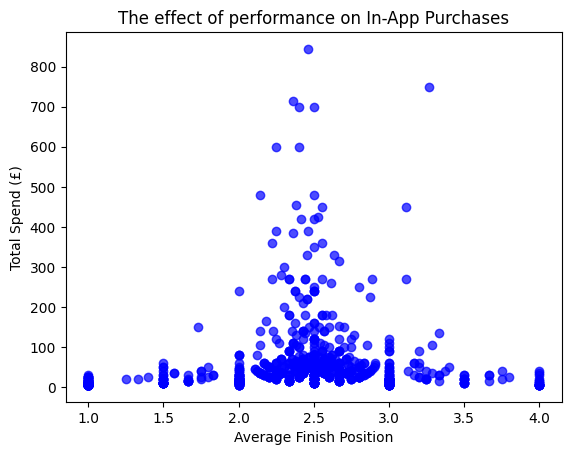

In [8]:
matches_vs_iap = pd.merge(matches, iap, on=['user_id', 'activity_date'], how='left', suffixes=('', '_purchase'))
matches_vs_iap['purchase_made'] = matches_vs_iap['dollar_purchase_value'].notna()
days_with_iap = matches_vs_iap[matches_vs_iap['purchase_made'] == True]

# Calculate performance metrics for days with purchases
performance_vs_iap = days_with_iap.groupby(['user_id', 'activity_date']).agg({
    'finish_position': ['mean', 'min', 'max'],
    'n_matches': 'sum',
    'dollar_purchase_value': 'sum'
}).reset_index()
performance_vs_iap.columns = ['user_id', 'activity_date', 'avg_finish_position', 'min_finish_position', 'max_finish_position', 'total_matches', 'total_purchase_value']
performance_vs_iap = performance_vs_iap.dropna(subset=['total_purchase_value', 'avg_finish_position'])

plt.scatter(performance_vs_iap['avg_finish_position'], performance_vs_iap['total_purchase_value'], color='blue', alpha=0.7)
plt.ylabel('Total Spend (£)')
plt.yticks(range(0, round(max(performance_vs_iap['total_purchase_value'])), 100))
plt.xlabel('Average Finish Position')
plt.title('The effect of performance on In-App Purchases')

plt.show()


### Virtual Purchases

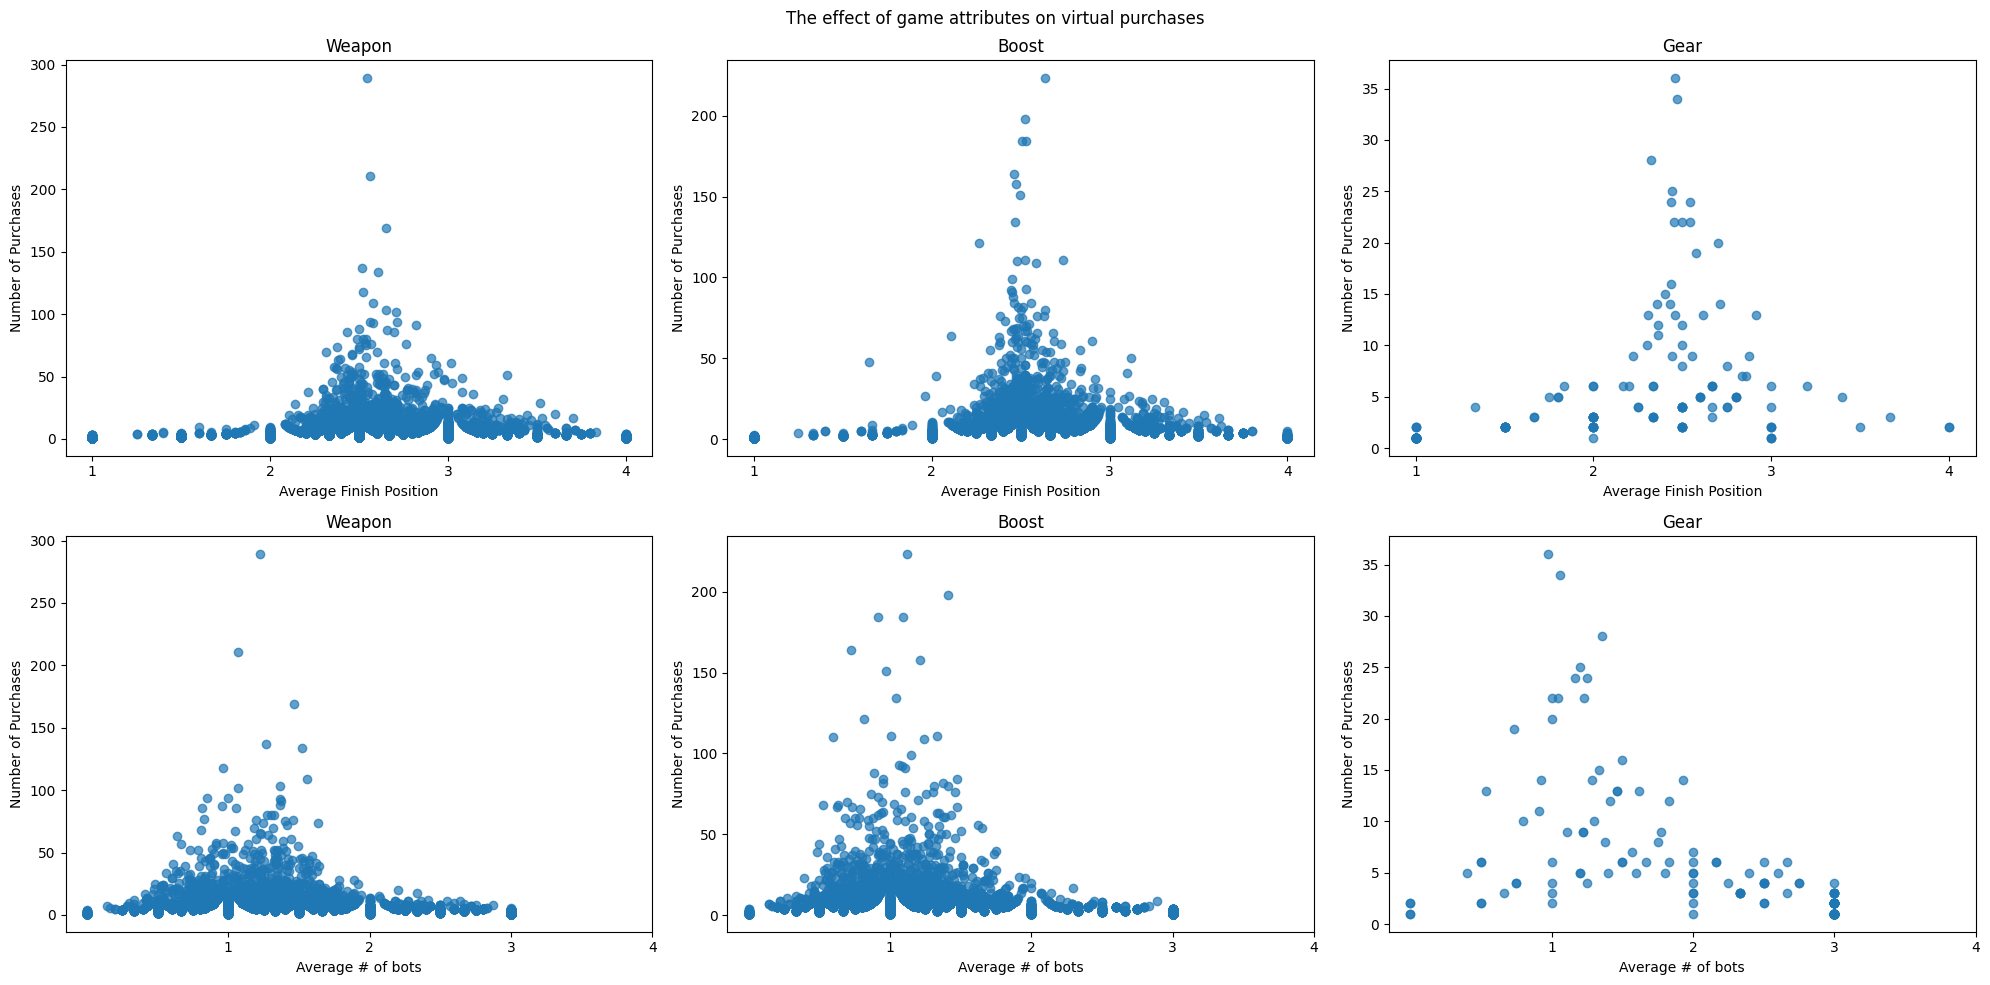

In [9]:
matches_vs_vp = pd.merge(matches, vp, on=['user_id', 'activity_date'], how='left', suffixes=('', '_purchase'))
matches_vs_vp['purchase_made'] = matches_vs_vp['gold_spend'].notna()
days_with_vp = matches_vs_vp[matches_vs_vp['purchase_made'] == True]

vp_agg = days_with_vp.groupby(['user_id', 'product_group']).agg({
    'finish_position': ['mean', 'min', 'max'],
    'bots': 'mean',
    'n_matches': 'sum',
    'gold_spend': ['sum', 'count']
}).reset_index()
vp_agg.columns = ['user_id', 'product_group', 'avg_finish_position', 'min_finish_position', 'max_finish_position', 'avg_bots', 'total_matches', 'total_spend', 'num_purchases']
vp_agg = vp_agg.dropna(subset=['num_purchases', 'avg_finish_position'])

fig, axes = plt.subplots(2,3, figsize=(20, 10))

for product_group, plot in zip(vp_agg['product_group'].unique(), axes[0]):
    subset = vp_agg[vp_agg['product_group'] == product_group]
    plot.scatter(subset['avg_finish_position'], subset['num_purchases'], label=product_group, alpha=0.7)
    plot.set_title(product_group)
    plot.set_ylabel('Number of Purchases')
    plot.set_xticks(range(1, 5, 1))
    plot.set_xlabel('Average Finish Position')

for product_group, plot in zip(vp_agg['product_group'].unique(), axes[1]):
    subset = vp_agg[vp_agg['product_group'] == product_group]
    plot.scatter(subset['avg_bots'], subset['num_purchases'], label=product_group, alpha=0.7)
    plot.set_title(product_group)
    plot.set_ylabel('Number of Purchases')
    plot.set_xticks(range(1, 5, 1))
    plot.set_xlabel('Average # of bots')

plt.suptitle('The effect of game attributes on virtual purchases')
plt.tight_layout()
plt.show()

The majority of purchases appear to be made when a player has finished between 2nd and 3rd place. There are two possible takeaways from this:
- Players will be rewarded more for finishing higher and therefore will have more currency to spend
- Players are approaching a winning position and, in working towards that, will feel that spending on improvements (mainly weapons and boosts) will help them reach victory.
- Whilst the distribution mainly centers around 2nd-3rd place, it is also worth noting that players are more likely to buy upgrades when between 3rd and 4th rather than near or achieving 1st place. This will be because, in 1st place, players have a lower reason to upgrade.


When looking at the effect of bots on purchase rates, it is interesting to see that players appear most likely to purchase when they are playing in games with majority human players. This could be due to a number of factors:

- Depending on the difficulty of the bots, players may find it harder when playing against human-dominated teams and therefore feel a higher need to improve.
- More human players in a match will most likely mean that there are a wider range of customisation and upgrade options selected by these players, this could almost act as an advert to the player as they will see an upgrade that they themself would like to purchase.

## Conclusions

Given my investigation, these are the findings that I think are worth considering:

- As long as there is one other human player in the team, there is no impact on the number of bots. 
  - Including at least one other human can have, on average, a 25% improvement over playing with only bots.

- Accurate matchmaking is important to ensure that player daily retention is optimised
  - Players should be given an appropriate challenge to allow them to feel like they are able to progress and reach the goal ahead of them, whilst not being too easy of a challenge.
  
- This matchmaking can also have a positive impact on the use of purchasing within the game
  - Players who are averaging 2nd or 3rd place games are more likely to play for longer as well as spend more on upgrades


### Further Steps

Given more time, I would look to implement machine learning to attempt to predict patterns of performance or behaviour leading to purchases both In-App and virtual. It would also be possible, whilst doing this, to build a classification for players to understand if they are high/low spenders or frequent/infrequent players. Using this classification it could also be possible to target matchmaking (as described above) to try and create game lobbies which are encouraging to the user and promote further play.

#### Example

A Random Forest model could take a players past game performance and purchase history and predict the likelihood of them making another purchase in the next few days. Through this, targeted advertisement or offers could be used to incentivise the player to play for longer or make these purchases.